In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import import_ipynb
from sklearn import metrics
import gnn
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, mean_squared_error, calinski_harabasz_score


Implementing K-means algorithm

In [44]:
gnn.model.eval()
embeddings = []
for data in gnn.test_loader:
    data = data.to(gnn.device)
    emb = gnn.model(data.x, data.edge_index).detach().cpu().numpy()
    embeddings.append(emb)

embeddings = np.concatenate(embeddings, axis=0)

kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
print(kmeans)

KMeans(n_clusters=3, random_state=0)


Visulaizing kmeans clusters

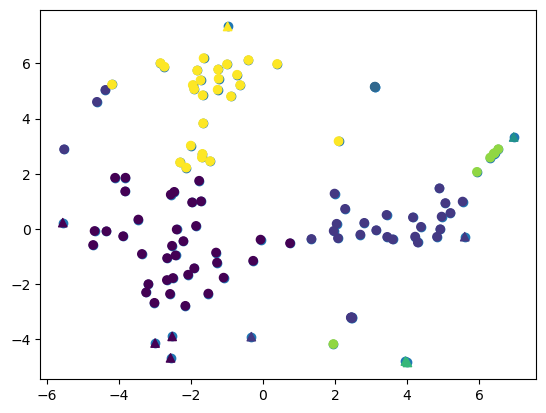

In [45]:
# Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
#print(np.shape(embeddings_scaled))

# Visualize using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_scaled)
#print(np.shape(embeddings_2d))
#print(np.shape(embeddings_2d[:, 0]))
#print(np.shape(embeddings_2d[:, 1]))
#print(embeddings_scaled)
#print(embeddings_2d)

vehicle_indices = list(gnn.train_vehicle_mapping.values())
tower_indices = list(gnn.train_tower_mapping.values())

vehicle_embeddings = embeddings[vehicle_indices]
tower_embeddings = embeddings[tower_indices]

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
#plt.scatter(embeddings_2d[:len(vehicle_indices), 0], embeddings_2d[:len(vehicle_indices), 1], c=vehicle_cluster_labels, cmap='viridis', marker='o', label='Vehicles')
#plt.scatter(embeddings_2d[len(vehicle_indices):, 0], embeddings_2d[len(vehicle_indices):, 1], c=tower_cluster_labels, cmap='viridis', marker='^', label='Towers')
#plt.show()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42).fit(embeddings_scaled)
labels = kmeans.labels_
#print (labels)
vehicle_cluster_labels = labels[:len(vehicle_indices)]
tower_cluster_labels = labels[len(vehicle_indices):]

# Visualize the clusters
#plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.scatter(embeddings_2d[:len(vehicle_indices), 0], embeddings_2d[:len(vehicle_indices), 1], c=vehicle_cluster_labels, cmap='viridis', marker='o', label='Vehicles')
plt.scatter(embeddings_2d[len(vehicle_indices):, 0], embeddings_2d[len(vehicle_indices):, 1], c=tower_cluster_labels, cmap='viridis', marker='^', label='Towers')
#plt.show()

Implementing some methods to process handovers

In [46]:
def select_best_tower(vehicle_id, cluster_towers):
    # Calculate cosine similarity between each vehicle and all towers

    vehicle_embedding = vehicle_embeddings[vehicle_id]
   
    best_tower = None
    best_similarity = np.inf  # Start with the worst possible value

    for tower in cluster_towers:
        tower_index = gnn.train_tower_mapping[tower]
        tower_embedding = tower_embeddings[tower_index - len(vehicle_indices)]  # Adjust index for towers

        # Calculate cosine similarity between vehicle and tower embeddings
        similarity = cosine_similarity([vehicle_embedding], [tower_embedding])[0][0]
        #print(tower)
        #similarity = euclidean_distances([vehicle_embedding], [tower_embedding])[0][0]

        if similarity < best_similarity:
            best_similarity = similarity
            best_tower = tower

    return best_tower

In [47]:
def make_handover_decision(vehicle_id, cluster_labels):
    #vehicle_cluster_labels = cluster_labels[:len(vehicle_indices)]
    vehicle_cluster_labels = cluster_labels[vehicle_id]
   
    #tower_cluster_labels = cluster_labels[len(vehicle_indices):]
   
    #vehicle_cluster = cluster_labels[vehicle_mapping[vehicle_id]]
    cluster_towers = [tower for tower, label in gnn.train_tower_mapping.items() if cluster_labels[label] == vehicle_cluster_labels]
    #cluster_towers = [tower for tower, label in tower_cluster_labels if cluster_labels[label] == vehicle_cluster_labels]
    if not cluster_towers:
        #raise ValueError(f"No towers found in the same cluster as vehicle {vehicle_id}")
        #print(f"No towers found in the same cluster as vehicle {vehicle_id}")
        best_tower = None
    else:
    # Calculate similarity or other criteria to select the best tower for handover
        
        #best_tower = select_best_tower(vehicle_id, cluster_towers, node_embeddings, tower_embeddings)
        best_tower = select_best_tower(vehicle_id, cluster_towers)
    return best_tower

In [48]:
edgeF = gnn.train_graph_data.edge_index.numpy()
edgeFF = gnn.test_graph_data.edge_index.numpy()  
pred = np.zeros((2,100), dtype=int)
index = 0
for vehicle, vehicle_id in gnn.train_vehicle_mapping.items():
    #print("yay")
    #print(vehicle)
    pred[0][index] = vehicle_id
    best_tower = make_handover_decision(vehicle_id, labels)
    if best_tower == None:
        best_tower = edgeF[1][vehicle_id] ##currentTower
        for tower, tower_id in gnn.train_tower_mapping.items():
            if tower_id == best_tower:
                best_tower = tower
                break
    for tower, tower_id in gnn.train_tower_mapping.items():
        if tower == best_tower:
            pred[1][index] = tower_id
            break  
    #print("pred= ", best_tower) 
    index = index + 1


getting accuracy of kmean cluster

In [49]:
# Calculate accuracy
true = edgeFF[:,:100] #future one
tureii = edgeF[:,:100] #old one
y_true = true[1,:]
y_truii = tureii[1,:]
y_pred = pred[1,:]
accuracy = accuracy_score(y_true, y_pred)
yoo = accuracy_score(y_truii, y_true)
acc = gnn.evaluate_model()
#print("Accuaracy before kmean cluster", acc)
#print("Accuracy:", accuracy)  # Output: Accuracy: 0.8
#print(yoo)



Performance Analysis

In [50]:
ss = silhouette_score(embeddings_scaled, labels) 
#print("silhouette score: " ,ss)
dbs = davies_bouldin_score(embeddings_scaled, labels) 
#print("davies bouldin score: ",dbs)
accuracy = accuracy_score(y_true, y_pred)
#print("Accuaracy score", accuracy)
mse = mean_squared_error(y_true, y_pred)
#print("Mean Squared Error: ", mse)
chs = calinski_harabasz_score(embeddings_scaled, labels)
#print("Calinski Harabasz Score: ", chs)
#print(metrics.cohen_kappa_score(y_true, y_pred))
f1 = metrics.f1_score(y_true, y_pred, average='micro')
ps = metrics.precision_score(y_true, y_pred, average='micro')
rs = metrics.recall_score(y_true, y_pred, average='micro')
vm = metrics.v_measure_score(y_true, y_pred)

#cluseter_center = kmeans.cluster_centers_
num_clusters = 7
#print(type(cluseter_center))
#print(cluseter_center)

node_intra_distances = np.zeros(num_clusters)
for cluster in range(num_clusters):
    cluster_mask = labels == cluster
    cluster_distances = np.linalg.norm(embeddings_scaled[cluster_mask] - kmeans.cluster_centers_[cluster], axis=1)
    node_intra_distances[cluster] = np.mean(cluster_distances)
node_avg_intra_distances = np.mean(node_intra_distances)
#print(node_avg_intra_distances)

node_inter_distances = np.zeros(num_clusters)
for cluster in range(num_clusters):
    other_clusters_centers = np.delete(kmeans.cluster_centers_, cluster, axis=0)
    cluster_distances = np.linalg.norm(other_clusters_centers - kmeans.cluster_centers_[cluster], axis=1)
    node_inter_distances[cluster] = np.mean(cluster_distances)
node_avg_inter_distances = np.mean(node_inter_distances)
#print(node_avg_inter_distances)

dist = node_avg_inter_distances/node_avg_intra_distances

#print(metrics.hamming_loss(y_true, y_pred)) maybeeeeeee
#print(metrics.jaccard_score(y_true, y_pred, average="micro"))
#print(metrics.matthews_corrcoef(y_true, y_pred))
#print(metrics.multilabel_confusion_matrix(y_true, y_pred))
#print(metrics.r2_score(y_true, y_pred))
#metrics.completeness_score(y_true, y_pred)
#print(metrics.mutual_info_score(y_true, y_pred))
#print(metrics.rand_score(y_true, y_pred))

'''
dists = metrics.pairwise.euclidean_distances(kmeans.cluster_centers_)
print(dists)
tri_dists = dists[np.triu_indices(5, 1)]
print(tri_dists)
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()
print(max_dist)
print(avg_dist)
print(min_dist)
max_dist, avg_dist, min_dist = dists.max(), dists.mean(), dists.min()
print(max_dist)
print(avg_dist)
print(min_dist)
'''

<class 'numpy.ndarray'>


'\ndists = metrics.pairwise.euclidean_distances(kmeans.cluster_centers_)\nprint(dists)\ntri_dists = dists[np.triu_indices(5, 1)]\nprint(tri_dists)\nmax_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()\nprint(max_dist)\nprint(avg_dist)\nprint(min_dist)\nmax_dist, avg_dist, min_dist = dists.max(), dists.mean(), dists.min()\nprint(max_dist)\nprint(avg_dist)\nprint(min_dist)\n'